In [14]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

from MEM_class import MEM

from synthData_Gen import SyntheticData_Gen

Generate a time series of synthetic data through an AR1 process:

In [133]:
s1_instance = SyntheticData_Gen(AR1_coef = 0.3, AR1_var = 120, AR1_dt = 0.001, AR1_N = 20000, diff_len=0.07, dt_sample = 0.025, meas_noise = 0.07)
s1 = s1_instance()

Plot said time series, both raw AR1 process and sampled/diffused series.

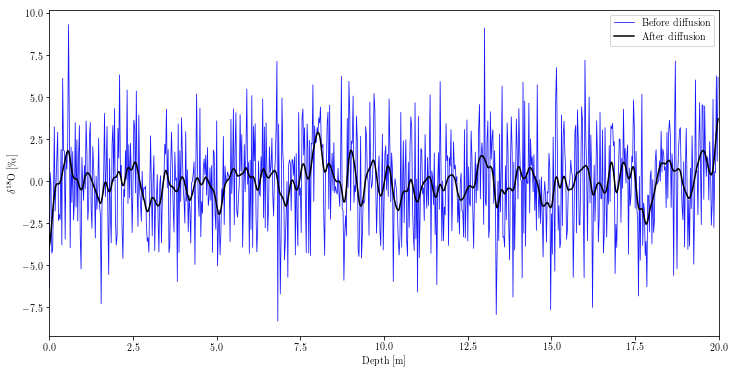

In [134]:
plotFig = True
if plotFig:
    figSynth, axSynth = plt.subplots(figsize=(12,6))
    axSynth.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]')
    axSynth.plot(s1[2],s1[3],linewidth=0.8, color='blue', alpha=0.9,label='Before diffusion')
    axSynth.plot(s1[4],s1[5], color='black', label='After diffusion')
    axSynth.legend()
    figSynth.savefig('SynthData.png')

Plot only the sampled/diffused data.

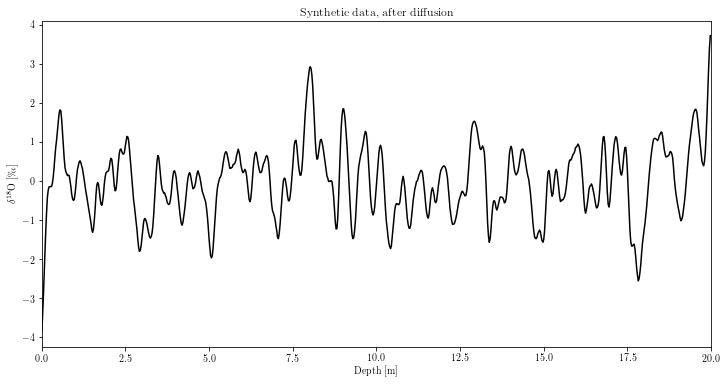

In [135]:
if plotFig:
    figSynthDiff, axSynthDiff = plt.subplots(figsize=(12,6))
    axSynthDiff.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]', title='Synthetic data, after diffusion')
    axSynthDiff.plot(s1[4],s1[5], color='black')


Define depth and signal data from synthetic data. Create an instance of a signal to use for spectral analysis.

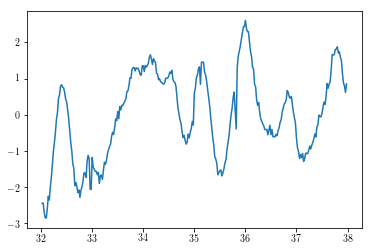

In [40]:
data = pd.read_csv('/home/thea/MesterTesen/Analysis/BCores_DataCode/CSV_files/Depth_d18O__B19.csv', '\t')

d18O = data['d18O'][(data['depth'] > 32) & (data['depth'] < 38)]
d18O = d18O - np.mean(d18O)
dep = data['depth'][(data['depth'] > 32) & (data['depth'] < 38)]
plt.plot(dep, d18O)

In [49]:
depth = np.asarray(dep)#s1[4]
data = np.asarray(d18O)#s1[5]
dt = depth[1] - depth[0]
N = 4096#data.size

d_fft = sp.fft.dct(data, 1, n = N)
f = np.fft.fftfreq(N,dt)
#f = np.linspace(0,1/dt, N)

d_psd = abs(d_fft[:N//2])**2

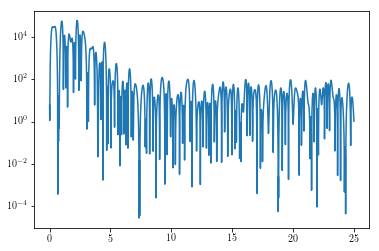

In [50]:
plt.semilogy(f[:N//2],d_psd)

In [51]:
def func_Noise(w, s_eta2, a1, dz):

    return (s_eta2**2 * dz) / (np.abs(1 - a1 * np.exp(- 2 * np.pi * 1j * w * dz))**2)

In [52]:
def func_Signal(w, p0, s_tot2):

    return p0 * np.exp(- (2 * np.pi * w * s_tot2)**2)

In [53]:

    
dt = depth[1] - depth[0]
N = 4096

fft = sp.fft.dct(data, 1, n = N) * dt
f = np.fft.fftfreq(2*N, dt)[:2*N//2]
P = abs(fft)**2

def calc_res(params, x, y, dt, weights):
    P0, s_eta2, s_tot2, a1 = params

    Noise = func_Noise(x, s_eta2, a1, dt)
    Signal = func_Signal(x, P0, s_tot2)

    Pmod = Noise + Signal
    res = weights*(np.log10(y) - np.log10(np.copy(Pmod)))
    
    return res

def sum2_res(params, x, y, dt, weights):

    return np.sum(calc_res(params, x, y, dt, weights)**2)

#Define the default boundaries for the different parameters.
boundas = {}
boundas['P0_Min'] = 1e-15
boundas['P0_Max'] = 100
boundas['s_eta2_Min'] = 1e-10
boundas['s_eta2_Max'] = 2
boundas['a1_Min'] = 1e-7
boundas['a1_Max'] = 0.2
boundas['s_tot2_Min'] = 1e-7
boundas['s_tot2_Max'] = 0.1

kwargs = {}
#If user has specified bounds for params, it is passed through here.
if list(kwargs.keys()):
    print('Setting fit param boundaries to user specifics')
    for j in list(kwargs.keys()):
        if j in list(bounds.keys()):
            bounds[j] = kwargs[j]
            print(f'setting {j} as {kwargs[j]}')
elif not list(kwargs.keys()):
    print('Using default boundaries for variance and a1')

#Initial parameter guess.
#p0 = [0.5, 1e-5, 0.05, 0.1]
p0 = [0.005, 0.005, 0.01, 0.1]

#Weights
weights = np.ones_like(f)*1.

#Optimization routine - minimizes residuals btw. data and model.
params_fit, fit_func_val, fit_dict = sp.optimize.fmin_l_bfgs_b(sum2_res, p0, fprime=None, args = (f, P, dt, weights),\
                                approx_grad=True, bounds = [(boundas['P0_Min'], boundas['P0_Max']), (boundas['s_eta2_Min'], boundas['s_eta2_Max']), \
                                (boundas['s_tot2_Min'], boundas['s_tot2_Max']), (boundas['a1_Min'], boundas['a1_Max'])])

P_fit = func_Noise(f, params_fit[1], params_fit[3], dt) + func_Signal(f, params_fit[0], params_fit[2])

opt_fit_dict = {"P0_fit": params_fit[0], "s_eta2_fit": params_fit[1], "s_tot2_fit": params_fit[2], "a1_fit": params_fit[3]}


Using default boundaries for variance and a1


Diff. len., fit [cm]: 10.000


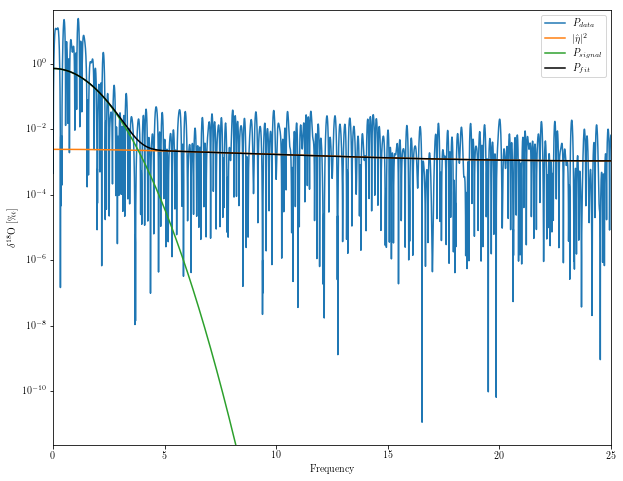

In [54]:
w_PSD = f 
P_PSD = P


Pnoise = func_Noise(w_PSD, opt_fit_dict['s_eta2_fit'],opt_fit_dict['a1_fit'], dt)
Psignal = func_Signal(w_PSD, opt_fit_dict['P0_fit'], opt_fit_dict['s_tot2_fit'])

plotFig = True
if plotFig == True:
    figPSDfit, axPSDfit = plt.subplots(figsize=(10,8))
    axPSDfit.set(ylim=(min(P_PSD)-min(P_PSD)*0.8, max(P_PSD)+max(P_PSD)*0.8), xlim=(min(w_PSD), max(w_PSD)),\
                ylabel='$\delta^{18}$O [\permil]', xlabel='Frequency')
    axPSDfit.semilogy(w_PSD, P_PSD, label='$P_{data}$')
    axPSDfit.semilogy(w_PSD, Pnoise, label='$|\hat{\eta}|^2$')
    axPSDfit.semilogy(w_PSD, Psignal, label='$P_{signal}$')
    axPSDfit.semilogy(w_PSD, P_fit, color='k', label='$P_{fit}$')
   # if psdType_in == 'FFT':
   #     axMEMfit.semilogy(w_PSD, P_Fit, color='k', label='$P_{fit}$')
   # elif psdType_in == 'MEM': 
   #     axMEMfit.semilogy(w_PSD, P_Fit[:-1], color='k', label='$P_{fit}$')
    axPSDfit.legend()
    #figPSDfit.savefig('FFT_PSD_fit.png')
s_eta2_fit = opt_fit_dict['s_eta2_fit']
s_tot2_fit = opt_fit_dict['s_tot2_fit']
#print(f'\nVariance, fit: {s_eta2_fit:.3f}')
print(f'Diff. len., fit [cm]: {s_tot2_fit*100:.3f}')

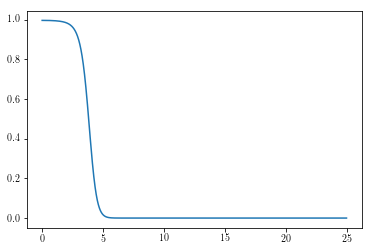

In [55]:
OptFilter = Psignal / (Pnoise + Psignal)

plt.plot(w_PSD, OptFilter)

In [56]:
s_eta2_fit**2

0.07901144233113397

In [57]:
sigma = 0.055
M = np.exp(-(2 * np.pi * w_PSD)**2 * sigma**2 / 2)

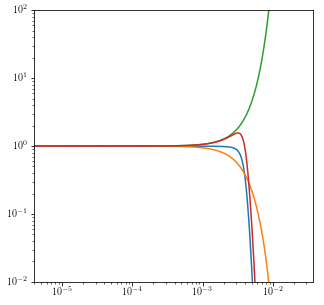

In [58]:
figFilters, axFilters = plt.subplots(figsize=(5,5))
axFilters.loglog(w_PSD/1000, OptFilter)
axFilters.loglog(w_PSD/1000, M)
axFilters.loglog(w_PSD/1000, M**(-1))
axFilters.loglog(w_PSD/1000, OptFilter * M**(-1))
axFilters.set_ylim((10**(-2),100));

In [59]:
R = OptFilter * M**(-1)
R

array([9.96627751e-01, 9.96629919e-01, 9.96636424e-01, ...,
       1.01329059e-88, 9.14854433e-89, 8.25960102e-89])

In [60]:
s = data
Nr = R.size
Ns = s.size

s_pad = np.append(s, np.zeros(5*Nr))
Npad = s_pad.size
k = Npad - Nr


r_pad = np.hstack((R[int(Nr/2):], np.zeros(k), R[:int(Nr/2)]))

Sf = np.fft.fft(s_pad)

conv = np.fft.ifft(Sf*r_pad)[:Ns]

/home/thea/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


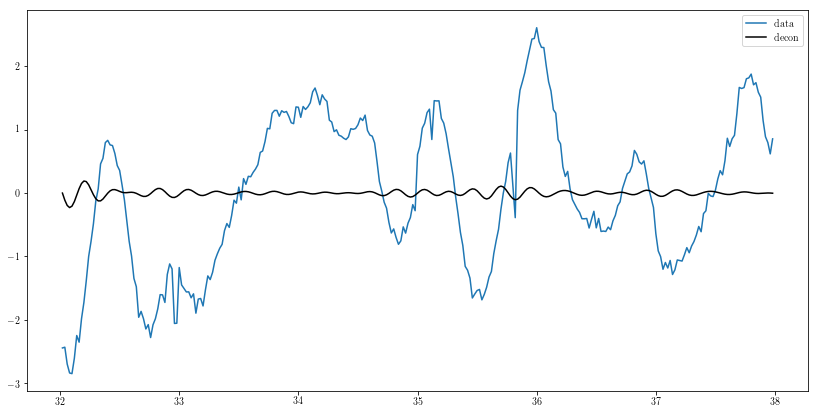

In [61]:
figDec, axDec = plt.subplots(figsize=(14,7))

axDec.plot(depth,data, label = 'data')
axDec.plot(depth, conv, label='decon', color='k')
axDec.legend()